In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input ,SpatialDropout3D,Dropout
import keras
from math import e
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from keras.models import load_model
from sklearn.decomposition import PCA

In [2]:
zLevData = xr.open_dataset('/home/cccr/diptih/dipti/Data/eraDown/ERA5_2degree_Down/2019_2020_verification/DailyMain/ERA5NH_500_z_daily.nc')
zLevData
z500=zLevData.z/9.81

z145E40N=z500.sel(latitude=40,longitude=145,method='nearest')
z20E55N=z500.sel(latitude=55,longitude=20,method='nearest')
z75E55N=z500.sel(latitude=55,longitude=75,method='nearest')
    #Calculate Anomaly
z145E40N_Anom = z145E40N.groupby("time.dayofyear") - z145E40N.groupby("time.dayofyear").mean("time")
z75E55N_Anom  = z75E55N.groupby("time.dayofyear")  - z75E55N.groupby("time.dayofyear").mean("time")
z20E55N_Anom  = z20E55N.groupby("time.dayofyear")  - z20E55N.groupby("time.dayofyear").mean("time")
    # calculate std normal anomalies
z145E40N_AnomStd = z145E40N_Anom.groupby("time.dayofyear")  / z145E40N.groupby("time.dayofyear").std("time")
z75E55N_AnomStd  = z75E55N_Anom.groupby("time.dayofyear")   / z75E55N.groupby("time.dayofyear").std("time")
z20E55N_AnomStd  = z20E55N_Anom.groupby("time.dayofyear")   / z20E55N.groupby("time.dayofyear").std("time")


EUVal = -(1.0/4.0)*z20E55N_AnomStd + (1.0/2.0)*z75E55N_AnomStd - (1.0/4.0)*z145E40N_AnomStd
EU_ds = xr.Dataset({'EU': (('time'), EUVal)}, coords={'time': zLevData.time})

EU_ds.to_netcdf('EUindex-NDJF-Daily-1979-2020.nc')
    

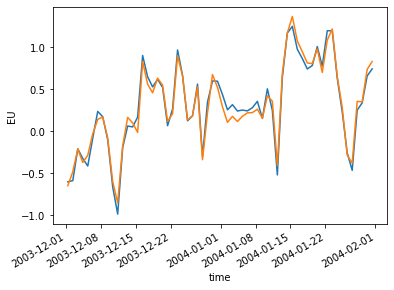

In [3]:
EUData = xr.open_dataset('../../../Data/AO_EU/EU.nc')
eu_old=EUData.EUVal[((EUData.EUVal.time.dt.month>11) | (EUData.EUVal.time.dt.month<2)) & 
                    (EUData.EUVal.time.dt.year<2020)].sel(time=slice('2003-12-1','2004-1-31'))
eu_old.plot()

eu_new=EU_ds.EU[((EU_ds.EU.time.dt.month>11) | (EU_ds.EU.time.dt.month<2)) & 
                    (EU_ds.EU.time.dt.year<2020)].sel(time=slice('2003-12-1','2004-1-31'))
eu_new.plot()

In [20]:
ZData = xr.open_dataset('/home/cccr/diptih/dipti/Data/eraDown/ERA5_2degree_Down/2019_2020_verification/DailyMain/weighted1000.nc')
    #slpData = xr.open_dataset('../eraDown/ERA5_2degree_Down/DailyMean/weighted1000.nc')
ZData.slp.values
ZData.slp.values=xr.where(np.isnan(ZData.slp.values),  0.000000000001,ZData.slp.values)
ZData.slp.values

t1=ZData.slp.stack(z=("lat", "longitude"))
    # fit scaler on training data
slp_PC =PCA().fit_transform(t1)

print(slp_PC[:,0].shape)
AO_ds = xr.Dataset({'AO': (('time'), slp_PC[:,0])}, coords={'time': ZData.time})

ZData.slp.values

(3864,)


array([[[  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [ 31.520903 ,  31.19795  ,  30.878622 , ...,  32.48614  ,
          32.16319  ,  31.840229 ],
        [ 44.060955 ,  43.265774 ,  42.485973 , ...,  46.400345 ,
          45.605156 ,  44.83562  ],
        ...,
        [149.77809  , 144.5983   , 145.34091  , ..., 160.02632  ,
         158.00266  , 154.7351   ],
        [143.78458  , 143.01772  , 144.3831   , ..., 150.25606  ,
         148.4044   , 146.23477  ],
        [133.05817  , 136.74872  , 139.72377  , ..., 140.83472  ,
         137.03119  , 133.58537  ]],

       [[  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  6.061774 ,   5.6553574,   5.252569 , ...,   7.3318286,
           6.907268 ,   6.482708 ],
        [ 15.783137 ,  14.464667 ,  13.166719 , ...,  19.646198 ,
          18.35851  ,  17.081083 ],
        ...,
        [145.82362  , 139.91974  , 139.23283  , ..., 1

In [21]:
norm = StandardScaler().fit(slp_PC[:,0].reshape(-1, 1))
    # transform training data
aoX = norm.transform(slp_PC[:,0].reshape(-1, 1))
aoX.shape

AO_ds = xr.Dataset({'AO': (('time'), aoX[:,0]*-1.0)}, coords={'time': ZData.time})

AO_ds.to_netcdf('AOindex-NDJF-Daily-1979-2020_old.nc')

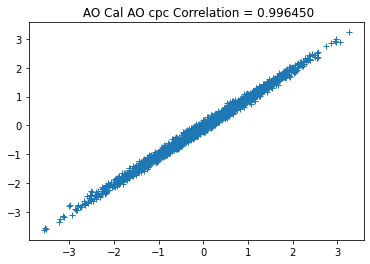

In [22]:
AOData = xr.open_dataset('../../../Data/AO_EU/AO_Calculated.nc')
eu_old=AOData.AO[((AOData.AO.time.dt.month>11) | (AOData.AO.time.dt.month<2)) & 
                    (AOData.AO.time.dt.year<2020)].sel(time=slice('1980-12-1','2019-1-31'))
#eu_old.plot()

eu_new=AO_ds.AO[((AO_ds.AO.time.dt.month>11) | (AO_ds.AO.time.dt.month<2)) & 
                    (AO_ds.AO.time.dt.year<2020)].sel(time=slice('1980-12-1','2019-1-31'))
#eu_new.plot()

test_corr = np.corrcoef(eu_old,eu_new)[0,1]
plt.title(' AO Cal AO cpc Correlation = %f'%test_corr)
plt.plot(eu_old,eu_new,'+')

